# File Setup

In [1]:
proxy = 'WM'
islet_id = 1
atoll = 'Nanumea'
max_year = 2021

import os
os.environ['OMP_NUM_THREADS'] = '1'
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import datetime
import itertools
import shapely 
from shapely.geometry import LineString, shape
import pyproj
import xarray as xr
import scipy
import pickle
from matplotlib.patches import ConnectionPatch
from sklearn.cluster import KMeans

#reversed in this notebook
transformer = \
    pyproj.Transformer.from_crs(pyproj.CRS("EPSG:4326"),pyproj.CRS("EPSG:32760")) 

# Load the data

In [2]:
with open('Processed_data_and_output/shorelines_dict.json','rb') as fp:
    shorelines_dict = pickle.load(fp)

In [3]:
for key,item in shorelines_dict.items():
    item = pd.DataFrame.from_dict(item,orient='index').T
    item['island'] = key[0]
    item['proxy'] = key[1]
    item['id'] = key[2]
    
    shorelines_dict.update({
        key:item
    })

In [4]:
df_all_shoreline_data = pd.concat([item for key,item in shorelines_dict.items()])

In [5]:
df_all_shoreline_data.index.rename('position',inplace=True)
df_all_shoreline_data.reset_index(drop=False,inplace=True)

In [6]:
df_all_shoreline_data = df_all_shoreline_data[df_all_shoreline_data.position<200] #some error points

In [7]:
# # Drop shoreline change values from the peninsular
# transformer2 = \
#     pyproj.Transformer.from_crs(pyproj.CRS("EPSG:32760"),pyproj.CRS("EPSG:4326")) 

# df_all_shoreline_data['y_with_nan'] = [y if transformer2.transform(x,y)[0]>-5.697555 else np.nan for x,y in zip(df_all_shoreline_data.x,df_all_shoreline_data.y) ]

# df_all_shoreline_data.dropna(inplace=True)

In [8]:
# Reset position zero point to be the most northerly point
transects_position_corrected_dict = {}

for year2,group in df_all_shoreline_data.groupby(['year2','island','proxy','id']):
    group['square'] = group.y**2#+group.x**2
    zero_point = (list(group[group.square==np.max(group.square)].position)[0])
    group['position'] = [x-zero_point if x>=zero_point else x-zero_point+1+np.max(group.position) for x in group.position]
    
    transects_position_corrected_dict.update({
        year2:group
    })
    
df_all_shoreline_data = pd.concat(transects_position_corrected_dict).reset_index(drop=True)
    

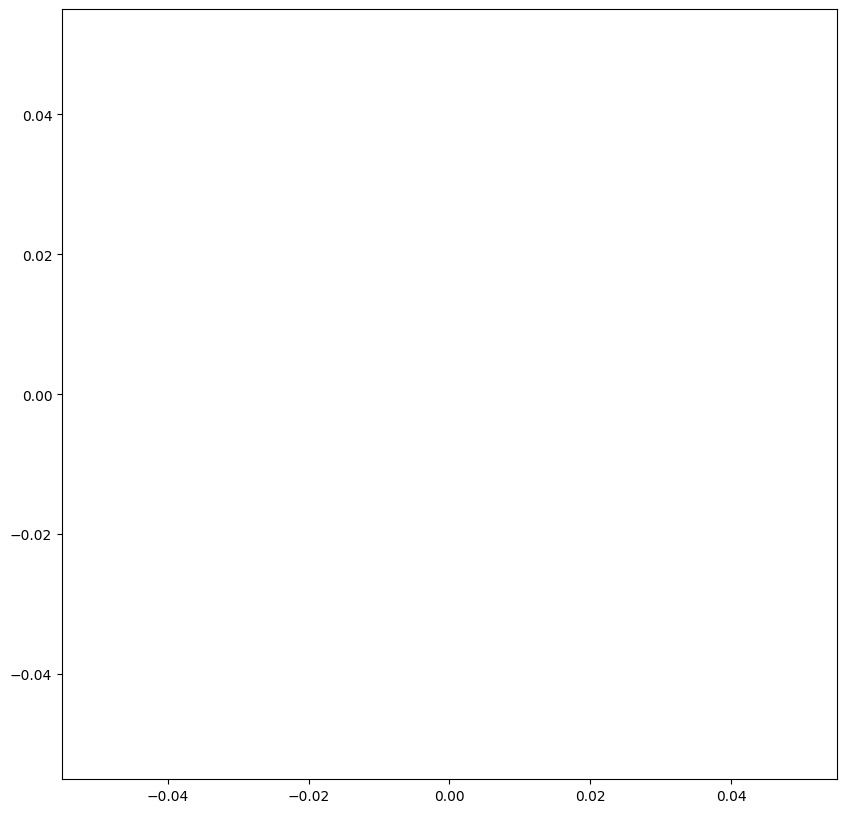

In [9]:
# Plot the shoreline position

fig = plt.figure(figsize=(10,10))

df_plot = df_all_shoreline_data[(df_all_shoreline_data.year2==2005)&(df_all_shoreline_data.island=='Nanumea')&(df_all_shoreline_data.id==1)]

output = plt.scatter(df_plot.x,df_plot.y,
                     c=df_plot.position,
                     cmap='RdBu',
                     alpha=0.2)



In [10]:
# Consider only TOB, Nanumea and main island
df_nanumea_TOB = df_all_shoreline_data[(df_all_shoreline_data.proxy==proxy)&(df_all_shoreline_data.island==atoll)&(df_all_shoreline_data.id==islet_id)&(df_all_shoreline_data.year2<=max_year)]

In [11]:
df_all_shoreline_data

,position,x,x+n,y,y+n,lon,lat,m_shoreline,m_transect,x_avg,...,intersect_distance,transect_angle,avg_slope_change,shoreline_direction,year1,year2,island,proxy,id,square
0,134,2.496633e+06,2.496674e+06,-727081.572567,-727148.378474,-97.275461,-71.257330,-1.642373,0.608875,2.496654e+06,...,-4.123989,31.336198,15.654719,58.663802,2002.375,2003.041667,Nanumea,WM,1,5.286476e+11
1,135,2.496674e+06,2.496705e+06,-727148.378474,-727221.062478,-97.274183,-71.256802,-2.320996,0.430850,2.496690e+06,...,-3.472522,23.308775,-0.205302,66.691225,2002.375,2003.041667,Nanumea,WM,1,5.287448e+11
2,136,2.496705e+06,2.496738e+06,-727221.062478,-727292.844478,-97.272671,-71.256332,-2.175069,0.459756,2.496722e+06,...,-10.838598,24.690873,-4.998640,65.309127,2002.375,2003.041667,Nanumea,WM,1,5.288505e+11
3,137,2.496738e+06,2.496778e+06,-727292.844478,-727360.770238,-97.271198,-71.255851,-1.694681,0.590081,2.496758e+06,...,-11.625131,30.544064,1.964821,59.455936,2002.375,2003.041667,Nanumea,WM,1,5.289549e+11
4,138,2.496778e+06,2.496807e+06,-727360.770238,-727433.916656,-97.269887,-71.255325,-2.559728,0.390666,2.496793e+06,...,-9.281635,21.338919,-0.119653,68.661081,2002.375,2003.041667,Nanumea,WM,1,5.290537e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12853,199,2.497939e+06,2.497967e+06,-731657.240532,-731717.734239,-97.174150,-71.233016,-2.190770,0.456460,2.497953e+06,...,-9.623938,24.534821,5.564825,65.465179,2002.375,2023.958333,Nanumea,WM,1,5.353223e+11
12854,0,2.497967e+06,2.497992e+06,-731717.734239,-731788.064444,-97.172910,-71.232612,-2.733096,0.365885,2.497980e+06,...,-0.359248,20.096835,-11.368172,69.903165,2002.375,2023.958333,Nanumea,WM,1,5.354108e+11
12855,2,2.496608e+06,2.496598e+06,-726950.411111,-727002.026361,-97.278486,-71.257927,5.309467,-0.188343,2.496603e+06,...,4.260095,-10.666298,8.951938,100.666298,2002.375,2023.958333,Nanumea,WM,1,5.284569e+11
12856,3,2.496598e+06,2.496641e+06,-727002.026361,-727057.788616,-97.277111,-71.257848,-1.299390,0.769592,2.496620e+06,...,4.707346,37.581594,-8.678431,52.418406,2002.375,2023.958333,Nanumea,WM,1,5.285319e+11


# Load summary wave data

In [12]:
# Load the data which is monthly summary and put it into an xarray
nanumea_spectra_dict = scipy.io.loadmat('Preprocessed_datasets/spectra/Nanumea_spec.mat')

days_since_jan_1979 = (nanumea_spectra_dict['tm']-np.min(nanumea_spectra_dict['tm']))[0,:]

dates_list = []
for timedelta in days_since_jan_1979:
    dates_list.append(datetime.datetime(1979,1,1)+datetime.timedelta(days=int(timedelta)))
    
dirs_list = [x[0] for x in nanumea_spectra_dict['dirs']]
dirs_list = dirs_list-np.min(dirs_list)
frqs = [x[0] for x in nanumea_spectra_dict['frqs']]

### Create feature for mean wave energy

In [13]:
xr_E_MM = xr.DataArray(data=nanumea_spectra_dict['E_MM'],coords=[dates_list,frqs,dirs_list],
                    dims=['time','freq','dirr'])

In [14]:
# # Convert the wave energy dataframes to wave energy anomaly, removing seasonality
# dates_indexed = pd.DatetimeIndex(np.array(xr_E_MM.time))
# xr_E_MM_anom = xr_E_MM.copy()
# for month in np.arange(1,13,1):
#     xr_E_MM_anom[[True if x.month==month else False for x in dates_indexed],:,:] = \
#                       xr_E_MM[[True if x.month==month else False for x in dates_indexed],:,:]-\
#                       np.mean(xr_E_MM[[True if x.month==month else False for x in dates_indexed],:,:],axis=1)


In [15]:
# xr_E_MM = xr_E_MM_anom.copy()

In [16]:
# nanumanga_dates = list(pd.read_csv('Preprocessed_datasets/Nanumaga_dates.tsv',sep='\t'))
# nanumanga_dates = \
#     [pd.to_datetime(x) for x in nanumanga_dates]


# nanumea_dates = list(pd.read_csv('Preprocessed_datasets/Nanumea_dates.tsv',sep='\t'))
# nanumea_dates = \
#     [pd.to_datetime(x) for x in nanumea_dates]

# nanumea_dict = {date.year:date for date in nanumea_dates}

In [17]:
# Reload dictionary from file
with open('dates_dict.pkl', 'rb') as f:
    nanumea_dict = pickle.load(f)

# Looking at just a few points for visualisation of correlations

In [18]:
years = np.sort(np.unique(df_nanumea_TOB.year2))

In [19]:
# create correlation xarrays over different time periods using either mean or 95th percentile

nanumea_with_waves = {}
pd.options.mode.chained_assignment = None  # default='warn'

def calc_correlations_array(days,window_size,xr_E):
    xr_E = xr_E.copy()
    
    years = np.unique(df_nanumea_TOB.year2)

    xr_E_last_month_t_0 = np.mean(xr_E[(xr_E.time>np.datetime64(nanumea_dict[years[0]]-datetime.timedelta(days=days)))&(xr_E.time<np.datetime64(nanumea_dict[years[0]])),:,:],axis=0) #-datetime.timedelta(days=days-window_size)
    xr_E_last_month_t_0 = xr_E_last_month_t_0.expand_dims(dim={'years':len(years)},axis=0)
    xr_E_last_month_t_0 = xr_E_last_month_t_0.assign_coords(years=years)
    xr_E_last_month_t_0 = xr_E_last_month_t_0.copy()

    for year,idx in zip(years[1:],np.arange(1,len(years),1)):
        xr_E_last_month = xr_E[(xr_E.time>np.datetime64(nanumea_dict[year]-datetime.timedelta(days=days)))&(xr_E.time<np.datetime64(nanumea_dict[year])),:,:] #-datetime.timedelta(days=days-window_size)

        xr_E_last_month = np.mean(xr_E_last_month,axis=0)

        xr_E_last_month_t_0[idx,:,:] = np.array(xr_E_last_month)

    # for year,df_year in df_nanumea_TOB.groupby('year2'):
    df_other_years = df_nanumea_TOB[df_nanumea_TOB.year2!=years[0]]
    df_first_year = df_nanumea_TOB[df_nanumea_TOB.year2==years[0]]

    # Collapes corrs for 2D plot
        
    df_first_year = df_nanumea_TOB[df_nanumea_TOB.year2==np.min(df_nanumea_TOB.year2)]

    (index,row) = [(index,row) for index,row in df_first_year.iterrows()][0]

    shoreline_change_per_year_single_position = {}
    for year in years:
        df = df_nanumea_TOB[df_nanumea_TOB.year2==year]
        df.loc[:,'euclidean_distance'] = (df.x-row.x)**2+(df.y-row.y)**2
        df = df[df.euclidean_distance==np.min(df.euclidean_distance)]

        shoreline_change_per_year_single_position.update({
            year:float(df.intersect_distance)
        })


    xr_TOB = xr.DataArray.from_dict({'dims':['years'],
                            'data':list(shoreline_change_per_year_single_position.values())})
    xr_TOB = xr_TOB.assign_coords(years=years)
    xr_TOB = xr_TOB.expand_dims(dim={'freq':xr_E_last_month_t_0.freq.values,
                                     'dirr':xr_E_last_month_t_0.dirr.values},axis=[1,2])

    xr_corrs = xr.corr(xr_TOB,xr_E_last_month_t_0,dim=['years'])
    xr_corrs = xr_corrs.sortby('dirr')
    xr_corrs['dirr'] = xr_corrs.dirr*np.pi/180
    xr_corr_init = xr_corrs.integrate('freq')

    position = np.arange(0,np.max(df_nanumea_TOB.position)+1,1)

    xr_corr_init = xr_corr_init.expand_dims(dim={'position':position},axis=0)
    xr_corr_init = xr_corr_init.assign_coords(position=position)
    xr_corr_init = xr_corr_init.copy()

    for index,row in df_first_year.iterrows():

        shoreline_change_per_year_single_position = {}
        for year in years:
            df = df_nanumea_TOB[df_nanumea_TOB.year2==year]
            df.loc[:,'euclidean_distance'] = (df.x-row.x)**2+(df.y-row.y)**2
            df = df[df.euclidean_distance==np.min(df.euclidean_distance)]

            shoreline_change_per_year_single_position.update({
                year:float(df.intersect_distance)
            })


        xr_TOB = xr.DataArray.from_dict({'dims':['years'],
                                'data':list(shoreline_change_per_year_single_position.values())})
        xr_TOB = xr_TOB.assign_coords(years=years)
        xr_TOB = xr_TOB.expand_dims(dim={'freq':xr_E_last_month_t_0.freq.values,
                                         'dirr':xr_E_last_month_t_0.dirr.values},axis=[1,2])

        xr_corrs = xr.corr(xr_TOB,xr_E_last_month_t_0,dim=['years'])
        xr_corrs = xr_corrs.sortby('dirr')
        xr_corrs['dirr'] = xr_corrs.dirr*np.pi/180
        xr_corrs = xr_corrs.fillna(0)
        xr_corrs = xr_corrs.integrate('freq')

        xr_corr_init[row.position,:] = np.array(xr_corrs)
        
    xr_corr_init['dirr'] = xr_corr_init.dirr*180/np.pi
    
    west_most_point = df_first_year[df_first_year.x==np.min(df_first_year.x)]
    north_most_point = df_first_year[df_first_year.y==np.max(df_first_year.y)]
    south_most_point = df_first_year[df_first_year.y==np.min(df_first_year.y)]
        
    return(xr_corr_init,west_most_point,north_most_point,south_most_point)


In [20]:
corrs_dict = {}
days_list = [31,62,93,124,120,180,244,360]
for wave_label,xr_E in zip(['mean'],[xr_E_MM]):
    for day in days_list:
        xr_corr_init,west_most_point,north_most_point,south_most_point = calc_correlations_array(day,day,xr_E)
        corrs_dict.update({
            (day,wave_label):{
                'corr':xr_corr_init,
                'west':west_most_point,
                'north':north_most_point,
                'south':south_most_point
            }
        })
        break
    break
  

In [21]:
xr_corr_init = xr_corr_init.fillna(0)

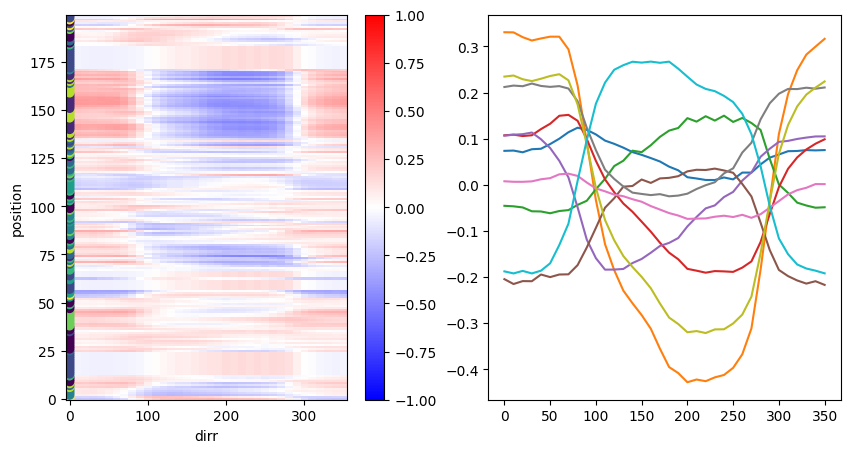

In [22]:
n_clusters = 10
fit = KMeans(n_clusters=n_clusters).fit(xr_corr_init)
clusts = fit.predict(xr_corr_init)

fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot2grid((1,2),(0,0),zorder=100)
ax2 = plt.subplot2grid((1,2),(0,1),zorder=100)

xr.plot.pcolormesh(xr_corr_init,ax=ax1,vmin=-1,vmax=1,cmap='bwr')
ax1.scatter([0]*len(clusts),np.arange(0,len(clusts),1),c=clusts)

for n in np.arange(0,n_clusters,1):
    ax2.plot(xr_corr_init.dirr,fit.cluster_centers_[n])


days: 90, window size: 90


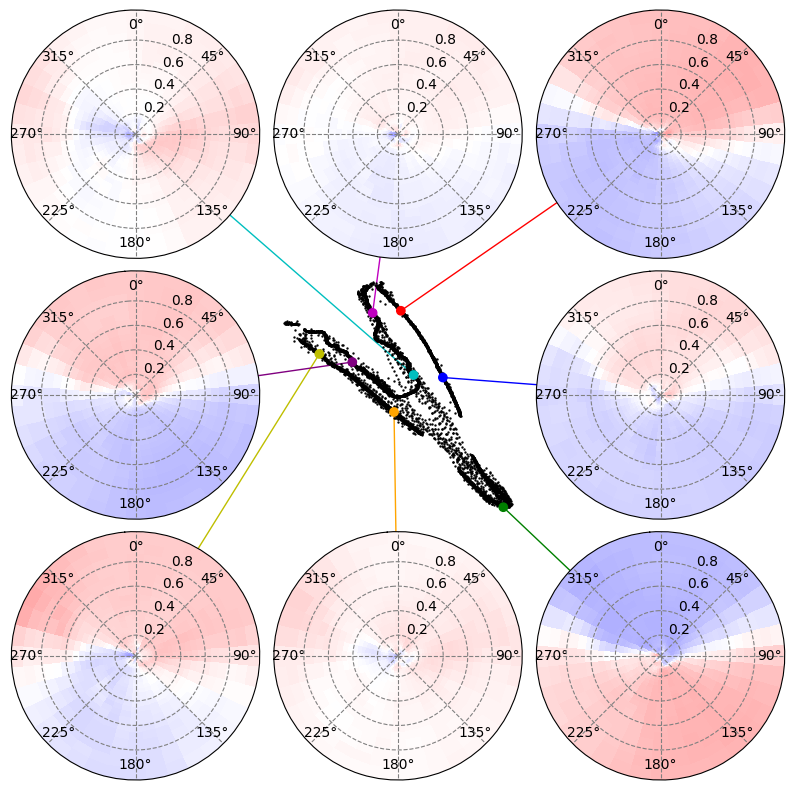

In [23]:
nanumea_with_waves = {}
pd.options.mode.chained_assignment = None  # default='warn'
# 31,60,90,120,180,244,360
days = 90
window_size = 90
xr_E = xr_E_MM.copy() ; dataset_name = 'mean'

print(f'days: {days}, window size: {window_size}')

fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot2grid((3,3),(0,2),projection='polar',zorder=100)
ax2 = plt.subplot2grid((3,3),(1,2),projection='polar',zorder=100)
ax3 = plt.subplot2grid((3,3),(2,2),projection='polar',zorder=100)
ax4 = plt.subplot2grid((3,3),(2,1),projection='polar',zorder=100)
ax5 = plt.subplot2grid((3,3),(2,0),projection='polar',zorder=100)
ax6 = plt.subplot2grid((3,3),(1,0),projection='polar',zorder=100)
ax7 = plt.subplot2grid((3,3),(0,0),projection='polar',zorder=100)
ax8 = plt.subplot2grid((3,3),(0,1),projection='polar',zorder=100)

ax9 = plt.subplot2grid((3,3),(1,1))

years = np.unique(df_nanumea_TOB.year2)

xr_E_last_month_t_0 = np.mean(xr_E[(xr_E.time>np.datetime64(nanumea_dict[years[0]]-datetime.timedelta(days=days)))&(xr_E.time<np.datetime64(nanumea_dict[years[0]]-datetime.timedelta(days=days-window_size))),:,:],axis=0)
xr_E_last_month_t_0 = xr_E_last_month_t_0.expand_dims(dim={'years':len(years)},axis=0)
xr_E_last_month_t_0 = xr_E_last_month_t_0.assign_coords(years=years)
xr_E_last_month_t_0 = xr_E_last_month_t_0.copy()

for year,idx in zip(years[1:],np.arange(1,len(years),1)):
    xr_E_last_month = xr_E[(xr_E.time>np.datetime64(nanumea_dict[year]-datetime.timedelta(days=days)))&(xr_E.time<np.datetime64(nanumea_dict[year]-datetime.timedelta(days=days-window_size))),:,:]
#     xr_E_95_last_month = xr_E_95[(xr_E_95.time>(nanumea_dict[year]-datetime.timedelta(days=days)))&(xr_E_95.time<(nanumea_dict[year])),:,:]
    
    xr_E_last_month = np.mean(xr_E_last_month,axis=0)
    
    xr_E_last_month_t_0[idx,:,:] = np.array(xr_E_last_month)

# for year,df_year in df_nanumea_TOB.groupby('year2'):
df_other_years = df_nanumea_TOB[df_nanumea_TOB.year2!=years[0]]
df_first_year = df_nanumea_TOB[df_nanumea_TOB.year2==years[0]]
position_selection = np.unique(df_first_year.position)[::int((len(df_first_year)/8))][0:8]#[1,25,50,75,100,125,150,175]

df_first_year_position_selected = df_first_year[df_first_year.position.isin(position_selection)]

for (index,row),ax in zip(df_first_year_position_selected.iterrows(),[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]):
    
    shoreline_change_per_year_single_position = {}
    for year in years:
        df = df_nanumea_TOB[df_nanumea_TOB.year2==year]
        df.loc[:,'euclidean_distance'] = (df.x-row.x)**2+(df.y-row.y)**2
        df = df[df.euclidean_distance==np.min(df.euclidean_distance)]
        
        shoreline_change_per_year_single_position.update({
            year:float(df.intersect_distance)
        })

        
    xr_TOB = xr.DataArray.from_dict({'dims':['years'],
                            'data':list(shoreline_change_per_year_single_position.values())})
    xr_TOB = xr_TOB.assign_coords(years=years)
    xr_TOB = xr_TOB.expand_dims(dim={'freq':xr_E_last_month_t_0.freq.values,
                                     'dirr':xr_E_last_month_t_0.dirr.values},axis=[1,2])

    xr_corrs = xr.corr(xr_TOB,xr_E_last_month_t_0,dim=['years'])
    xr_corrs = xr_corrs.sortby('dirr')
    xr_corrs['dirr'] = xr_corrs.dirr*np.pi/180

    xr.plot.pcolormesh(xr_corrs,ax=ax,vmin=-1,vmax=1,cmap='bwr',add_colorbar=False)#,add_colorbar=[False if ax!=ax1 else True for ax in [ax]][0])
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location("N")
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticks(ax.get_yticks()[:-2])
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.tick_params(axis="x",direction="in",pad=-18)
    handles, labels = ax.get_legend_handles_labels()
    
# ax1.legend(handles,labels,loc='right',bbox_to_anchor=(0.5,0.5))
    
colours = ['r','b','g','orange','y','purple','c','m']
# Create centre plot
ax9.scatter(df_nanumea_TOB.x,df_nanumea_TOB.y,c='k',s=0.5)
ax9.scatter(df_first_year_position_selected.x,df_first_year_position_selected.y,c=colours)
ax9.axis('off')


for c,index,ax in zip(colours,np.arange(0,len(colours),1),[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]):
    # Create connections
    axb = fig.add_axes(ax.get_position(), frameon=False,zorder=-1000)
    axb.axis('off')
    
    con = ConnectionPatch(xyA=(df_first_year_position_selected.reset_index().loc[index,'x'],
                               df_first_year_position_selected.reset_index().loc[index,'y']),
                          xyB=(np.mean(axb.get_xlim()),np.mean(axb.get_ylim())), coordsA="data", coordsB="data",
                          axesA=ax9, axesB=axb, color=c,zorder=-1000)

    ax9.add_artist(con)
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.savefig(f'Processed_data_and_output/figures/polar_example_plot_{dataset_name}_{window_size}.png')


In [24]:
# Plot the correlations around the shoreline integrating over frequencies
# make this one with a little slider

In [25]:
df_first_year = df_nanumea_TOB[df_nanumea_TOB.year2==np.min(df_nanumea_TOB.year2)]

(index,row) = [(index,row) for index,row in df_first_year.iterrows()][0]

shoreline_change_per_year_single_position = {}
for year in years:
    df = df_nanumea_TOB[df_nanumea_TOB.year2==year]
    df.loc[:,'euclidean_distance'] = (df.x-row.x)**2+(df.y-row.y)**2
    df = df[df.euclidean_distance==np.min(df.euclidean_distance)]

    shoreline_change_per_year_single_position.update({
        year:float(df.intersect_distance)
    })


xr_TOB = xr.DataArray.from_dict({'dims':['years'],
                        'data':list(shoreline_change_per_year_single_position.values())})
xr_TOB = xr_TOB.assign_coords(years=years)
xr_TOB = xr_TOB.expand_dims(dim={'freq':xr_E_last_month_t_0.freq.values,
                                 'dirr':xr_E_last_month_t_0.dirr.values},axis=[1,2])

xr_corrs = xr.corr(xr_TOB,xr_E_last_month_t_0,dim=['years'])
xr_corrs = xr_corrs.sortby('dirr')
xr_corrs['dirr'] = xr_corrs.dirr*np.pi/180
xr_corr_init = xr_corrs.integrate('freq')

position = np.arange(0,np.max(df_nanumea_TOB.position)+1,1)

xr_corr_init = xr_corr_init.expand_dims(dim={'position':position},axis=0)
xr_corr_init = xr_corr_init.assign_coords(position=position)
xr_corr_init = xr_corr_init.copy()

for index,row in df_first_year.iterrows():
    
    shoreline_change_per_year_single_position = {}
    for year in years:
        df = df_nanumea_TOB[df_nanumea_TOB.year2==year]
        df.loc[:,'euclidean_distance'] = (df.x-row.x)**2+(df.y-row.y)**2
        df = df[df.euclidean_distance==np.min(df.euclidean_distance)]
        
        shoreline_change_per_year_single_position.update({
            year:float(df.intersect_distance)
        })

        
    xr_TOB = xr.DataArray.from_dict({'dims':['years'],
                            'data':list(shoreline_change_per_year_single_position.values())})
    xr_TOB = xr_TOB.assign_coords(years=years)
    xr_TOB = xr_TOB.expand_dims(dim={'freq':xr_E_last_month_t_0.freq.values,
                                     'dirr':xr_E_last_month_t_0.dirr.values},axis=[1,2])

    xr_corrs = xr.corr(xr_TOB,xr_E_last_month_t_0,dim=['years'])
    xr_corrs = xr_corrs.sortby('dirr')
    xr_corrs['dirr'] = xr_corrs.dirr*np.pi/180
    xr_corrs = xr_corrs.fillna(0)
    xr_corrs = xr_corrs.integrate('freq')

    xr_corr_init[row.position,:] = np.array(xr_corrs)
xr_corr_init['dirr'] = xr_corr_init.dirr*180/np.pi

In [26]:
left_most_point = df_first_year[df_first_year.x==np.min(df_first_year.x)]
north_most_point = df_first_year[df_first_year.y==np.max(df_first_year.y)]
south_most_point = df_first_year[df_first_year.y==np.min(df_first_year.y)]

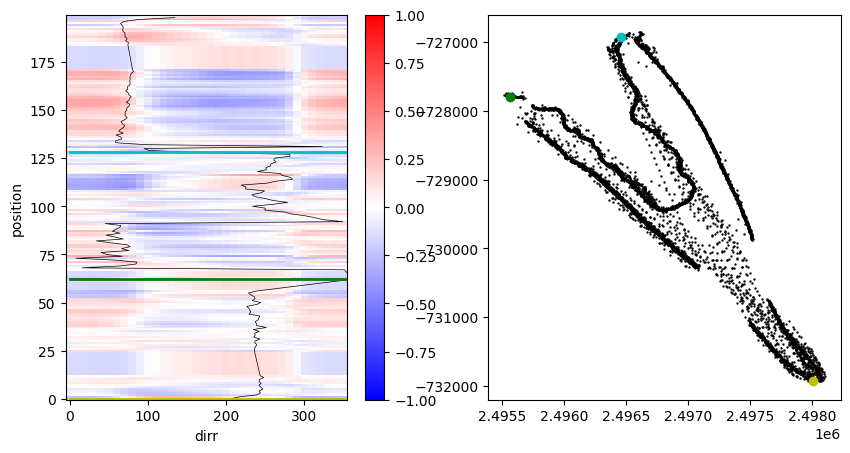

In [27]:
fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot2grid((1,2),(0,0))
ax2 = plt.subplot2grid((1,2),(0,1))

xr.plot.pcolormesh(xr_corr_init,cmap='bwr',vmin=-1,vmax=1,add_colorbar=True,ax=ax1)

ax2.scatter(df_nanumea_TOB.x,df_nanumea_TOB.y,c='k',s=0.5)

ax2.scatter(left_most_point.x,left_most_point.y,c='g')
ax2.scatter(north_most_point.x,north_most_point.y,c='c')
ax2.scatter(south_most_point.x,south_most_point.y,c='y')


df_year = df_nanumea_TOB[df_nanumea_TOB.year2==np.min(df_nanumea_TOB.year2)]
df_year = df_year.sort_values('position')
ax1.plot(df_year.shoreline_direction,df_year.position,c='k',lw=0.5)

ax1.plot([0,360],[left_most_point.position,left_most_point.position],c='g',lw=2)
ax1.plot([0,360],[north_most_point.position,north_most_point.position],c='c',lw=2)
ax1.plot([0,360],[south_most_point.position,south_most_point.position],c='y',lw=2)




# New Clustering Method

In [28]:
def find_coordinate_index(data_array, coordinate_name, value):
    """
    Find the index of a coordinate in an xarray equal to a particular value.
    
    Parameters:
        data_array (xarray.DataArray): The xarray data array.
        coordinate_name (str): The name of the coordinate to search.
        value: The value to search for in the coordinate.
    
    Returns:
        tuple or None: The index of the coordinate if found, or None if not found.
    """
    coordinate = data_array[coordinate_name]
    index = coordinate.to_index().get_loc(value, method='nearest')
    if isinstance(index, int):
        return (index,)
    elif isinstance(index, slice):
        return index.indices(len(coordinate))
    else:
        return None

In [29]:
# create correlation xarrays over different time periods using either mean or 95th percentile
pd.options.mode.chained_assignment = None  # default='warn'

def calc_correlations_array_multidim(month,xr_E,anomaly):
    xr_E = xr_E.copy()
    
    years = np.unique(df_nanumea_TOB.year2)
    current_time_index = find_coordinate_index(xr_E,'time',
                                               np.array(xr_E[xr_E.time>np.datetime64(nanumea_dict[years[0]])].time)[0])[0]-1

    xr_E_last_month_t_0 = np.mean(xr_E[(current_time_index-month):(current_time_index-(month-1)),:,:],axis=0)
    xr_E_init = xr_E_last_month_t_0.copy()
    xr_E_last_month_t_0 = xr_E_last_month_t_0.expand_dims(dim={'years':len(years)},axis=0)
    xr_E_last_month_t_0 = xr_E_last_month_t_0.assign_coords(years=years)
    xr_E_last_month_t_0 = xr_E_last_month_t_0.copy()

    for year,idx in zip(years[1:],np.arange(1,len(years),1)):
        current_time_index = find_coordinate_index(xr_E,'time',
                                                   np.array(xr_E[xr_E.time>np.datetime64(nanumea_dict[year])].time)[0])[0]-1
        
        xr_E_last_month = np.mean(xr_E[(current_time_index-month):(current_time_index-(month-1)),:,:],axis=0)
        if anomaly:
            xr_E_last_month = xr_E_last_month-xr_E_init
        xr_E_last_month = np.mean(xr_E_last_month,axis=0)
        xr_E_last_month_t_0[idx,:,:] = np.array(xr_E_last_month)


    # for year,df_year in df_nanumea_TOB.groupby('year2'):
    df_other_years = df_nanumea_TOB[df_nanumea_TOB.year2!=years[0]]
    df_first_year = df_nanumea_TOB[df_nanumea_TOB.year2==years[0]]

    # Collapes corrs for 2D plot
        
    df_first_year = df_nanumea_TOB[df_nanumea_TOB.year2==np.min(df_nanumea_TOB.year2)]

    (index,row) = [(index,row) for index,row in df_first_year.iterrows()][0]

    shoreline_change_per_year_single_position = {}
    for year in years:
        
        df = df_nanumea_TOB[df_nanumea_TOB.year2==year]
        df.loc[:,'euclidean_distance'] = (df.x-row.x)**2+(df.y-row.y)**2
        df = df[df.euclidean_distance==np.min(df.euclidean_distance)]

        shoreline_change_per_year_single_position.update({
            year:float(df.intersect_distance)
        })


    xr_TOB = xr.DataArray.from_dict({'dims':['years'],
                            'data':list(shoreline_change_per_year_single_position.values())})
    xr_TOB = xr_TOB.assign_coords(years=years)
    xr_TOB = xr_TOB.expand_dims(dim={'freq':xr_E_last_month_t_0.freq.values,
                                     'dirr':xr_E_last_month_t_0.dirr.values},axis=[1,2])

    xr_corrs = xr.corr(xr_TOB,xr_E_last_month_t_0,dim=['years'])
    xr_corrs = xr_corrs.sortby('dirr')
    xr_corrs['dirr'] = xr_corrs.dirr*np.pi/180
    xr_corr_init = xr_corrs
#     xr_corr_init = xr_corrs.integrate('freq')

    position = np.arange(0,np.max(df_nanumea_TOB.position)+1,1)

    xr_corr_init = xr_corr_init.expand_dims(dim={'position':position},axis=0)
    xr_corr_init = xr_corr_init.assign_coords(position=position)
    xr_corr_init = xr_corr_init.copy()

    for index,row in df_first_year.iterrows():

        shoreline_change_per_year_single_position = {}
        for year in years:
            df = df_nanumea_TOB[df_nanumea_TOB.year2==year]
            df.loc[:,'euclidean_distance'] = (df.x-row.x)**2+(df.y-row.y)**2
            df = df[df.euclidean_distance==np.min(df.euclidean_distance)]

            shoreline_change_per_year_single_position.update({
                year:float(df.intersect_distance)
            })


        xr_TOB = xr.DataArray.from_dict({'dims':['years'],
                                'data':list(shoreline_change_per_year_single_position.values())})
        xr_TOB = xr_TOB.assign_coords(years=years)
        xr_TOB = xr_TOB.expand_dims(dim={'freq':xr_E_last_month_t_0.freq.values,
                                         'dirr':xr_E_last_month_t_0.dirr.values},axis=[1,2])

        xr_corrs = xr.corr(xr_TOB,xr_E_last_month_t_0,dim=['years'])
        xr_corrs = xr_corrs.sortby('dirr')
        xr_corrs['dirr'] = xr_corrs.dirr*np.pi/180
        xr_corrs = xr_corrs.fillna(0)
        xr_corrs = xr_corrs.integrate('freq')

        xr_corr_init[row.position,:] = np.array(xr_corrs)
        
    xr_corr_init['dirr'] = xr_corr_init.dirr*180/np.pi
            
    return(xr_corr_init)


In [30]:
months_list = np.arange(1,13,1)

xr_corr_multidim = calc_correlations_array_multidim(months_list[0],xr_E_MM,False)


xr_corr_multidim = xr_corr_multidim.expand_dims(dim={'window_size':months_list},axis=[3])
xr_corr_multidim = xr_corr_multidim.assign_coords(window_size=months_list)
xr_corr_multidim = xr_corr_multidim.copy()
    
for month in months_list[1:]:
    xr_corr = calc_correlations_array_multidim(month,xr_E_MM,False)
    
    xr_corr_multidim[:,:,:,month-1] = xr_corr #month -1 because it's the index not the month itself

xr_corr_multidim.to_netcdf('Processed_data_and_output/correlations.nc')

# Linear relationships in an N-dimensional array

In [33]:
xr_corr_multidim

<xarray.DataArray (position: 200, freq: 37, dirr: 36, window_size: 12)>
array([[[[-3.51861355e-01, -8.99122790e-02, -3.89701005e-02, ...,
          -7.12574084e-02,  9.86287755e-02, -1.30607968e-01],
         [-3.46857244e-01, -1.05859336e-01, -1.24426090e-01, ...,
          -6.47634094e-02,  1.68657793e-01, -6.41276541e-02],
         [-3.24088860e-01, -1.21252478e-01, -2.07062676e-01, ...,
          -5.31023148e-02,  2.23355228e-01,  1.94576093e-02],
         ...,
         [-3.62060685e-01, -6.45301260e-02, -1.60664739e-02, ...,
          -1.43428139e-01,  2.48625584e-02, -1.52049233e-01],
         [-3.61879203e-01, -5.51908731e-02,  1.87582146e-02, ...,
          -1.15604915e-01,  2.48509968e-02, -1.45124452e-01],
         [-3.55554824e-01, -5.53161022e-02,  2.46043796e-02, ...,
          -1.00930888e-01,  3.56921205e-02, -1.40467654e-01]],

        [[-3.51861355e-01, -8.99122790e-02, -3.89701005e-02, ...,
          -7.12574084e-02,  9.86287755e-02, -1.30607968e-01],
         [-3.46857244e-01, -1.05859336e-01, -1.24426090e-01, ...,
          -6.47634094e-02,  1.68657793e-01, -6.41276541e-02],
         [-3.24088860e-01, -1.21252478e-01, -2.07062676e-01, ...,
          -5.31023148e-02,  2.23355228e-01,  1.94576093e-02],
...
         [-8.79569721e-02, -1.03120400e-01, -1.14628613e-01, ...,
          -1.41723134e-01,  2.27695057e-01, -2.85672082e-02],
         [-8.39671708e-02, -1.22740741e-01, -1.26146664e-01, ...,
          -1.29796156e-01,  1.87646283e-01,  1.28617872e-03],
         [-7.54557357e-02, -1.36851970e-01, -1.44001516e-01, ...,
          -1.19120722e-01,  1.60910840e-01,  1.89137954e-02]],

        [[-6.79049931e-02, -1.45931531e-01, -2.06343404e-01, ...,
          -9.65062917e-02,  1.24931100e-01,  1.11830028e-02],
         [-5.41165987e-02, -1.64273258e-01, -2.59731509e-01, ...,
          -9.44335890e-02,  1.37159198e-01, -3.46764859e-02],
         [-3.76632174e-02, -1.82119518e-01, -2.98331159e-01, ...,
          -8.37724599e-02,  1.56659548e-01, -9.60077742e-02],
         ...,
         [-8.79334821e-02, -1.03111171e-01, -1.14621191e-01, ...,
          -1.41719645e-01,  2.27705315e-01, -2.85629579e-02],
         [-8.39493183e-02, -1.22731374e-01, -1.26141765e-01, ...,
          -1.29793096e-01,  1.87657137e-01,  1.29031993e-03],
         [-7.54388042e-02, -1.36841142e-01, -1.43997864e-01, ...,
          -1.19118673e-01,  1.60919566e-01,  1.89176320e-02]]]])
Coordinates:
  * window_size  (window_size) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * position     (position) int64 0 1 2 3 4 5 6 ... 193 194 195 196 197 198 199
  * freq         (freq) float64 0.033 0.0363 0.0399 0.0439 ... 0.8274 0.9096 1.0
  * dirr         (dirr) float64 0.0 10.0 20.0 30.0 ... 320.0 330.0 340.0 350.0

In [34]:
# Calculate correlations between all pairs of arrays
corr_matrix = np.corrcoef(xr_corr_multidim.values.reshape(200, -1))

# Create dictionary to store similarities
array_similarities_dict = {}
for i in range(199):
    array_similarities_dict[i] = {j: corr_matrix[i, j] for j in range(199)}

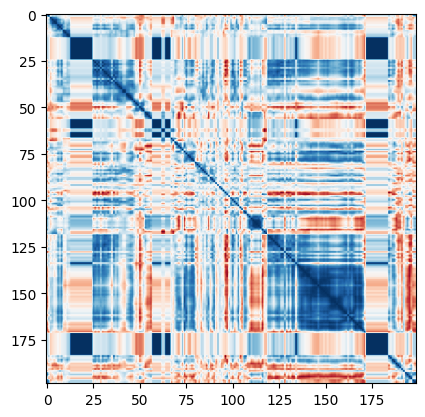

In [35]:
df = pd.DataFrame.from_dict(array_similarities_dict,orient='index')

plt.imshow(df,'RdBu')
plt.savefig('Processed_data_and_output/figures/confusion_matrix.png')

In [36]:
n_clusters = 6

df = pd.DataFrame.from_dict(array_similarities_dict,orient='index')
fit = KMeans(n_clusters=n_clusters).fit(df)
clusts = fit.predict(df)
df_new = df.copy()
df_new = df_new.reset_index().rename(columns={'index':'position'})
df_new.index = clusts
df_new = df_new.sort_index()

In [37]:
len_clusts = []
for clust in np.unique(clusts):
    len_clusts.append(len(df_new[df_new.index==clust]))

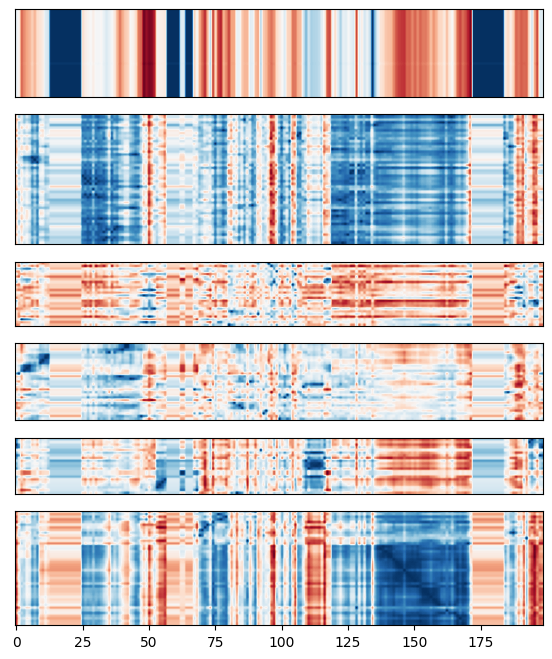

In [38]:

fig, ax = plt.subplots(n_clusters, 1, figsize=(8,8), gridspec_kw={'height_ratios': 
                                                   len_clusts})

i = 0
for clust in np.unique(clusts):
    df_clust_temp = df_new[df_new.index==clust]
    # ax1 = plt.subplot2grid((n_clusters,1),(i,0),zorder=100)
    ax[i].imshow(df_clust_temp.drop('position',axis=1),'RdBu')
    ax[i].axes.get_yaxis().set_visible(False)
    if clust!=np.max(clusts):
        ax[i].axes.get_xaxis().set_visible(False)
    i+=1

plt.savefig('Processed_data_and_output/figures/clustered_confusion_matrix.png')

In [39]:
# Saves these clusts for tests in the other file
dict_temp = df_new['position'].reset_index().set_index(['position']).to_dict()['index']
with open('Processed_data_and_output/clusters.json','wb') as fp:
    pickle.dump(dict_temp,fp)